In [1]:
!pip install lmfit yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import matplotlib.pyplot as plt
import lmfit
import random
from matplotlib.offsetbox import AnchoredText
import bs4
import datetime
from scipy import stats
import seaborn as sns
sns.set(style="darkgrid", palette="muted", color_codes=True)
import yfinance as yf

/tmp/ipython-input-2520319819.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, start=start, end=end)#.resample('W').last()
[*********************100%***********************]  1 of 1 completed


np.int64(133)

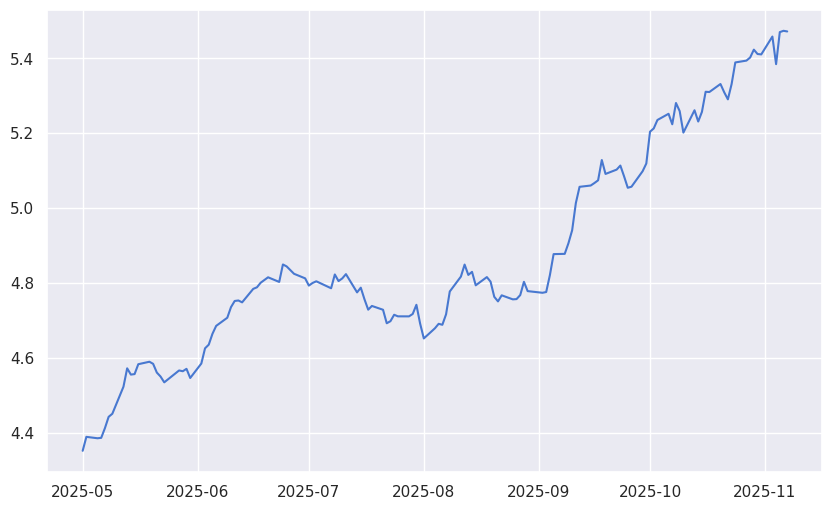

In [14]:

# 获取股票数据
stock = "MU"
start = "2025-5-1"
end = datetime.date.today()
df = yf.download(stock, start=start, end=end)#.resample('W').last()

# 删除 Ticker 这一行
df.columns = df.columns.droplevel(1)
signal=np.log(df['Close'])
# dates = pd.date_range(start="2024-11-01", periods=len(signal), freq="W")

time=np.arange(len(signal))
plt.figure(figsize=(10,6))
plt.plot(signal)
df['Close'].count()


0
1
2
3
4
5
6
7
8
9


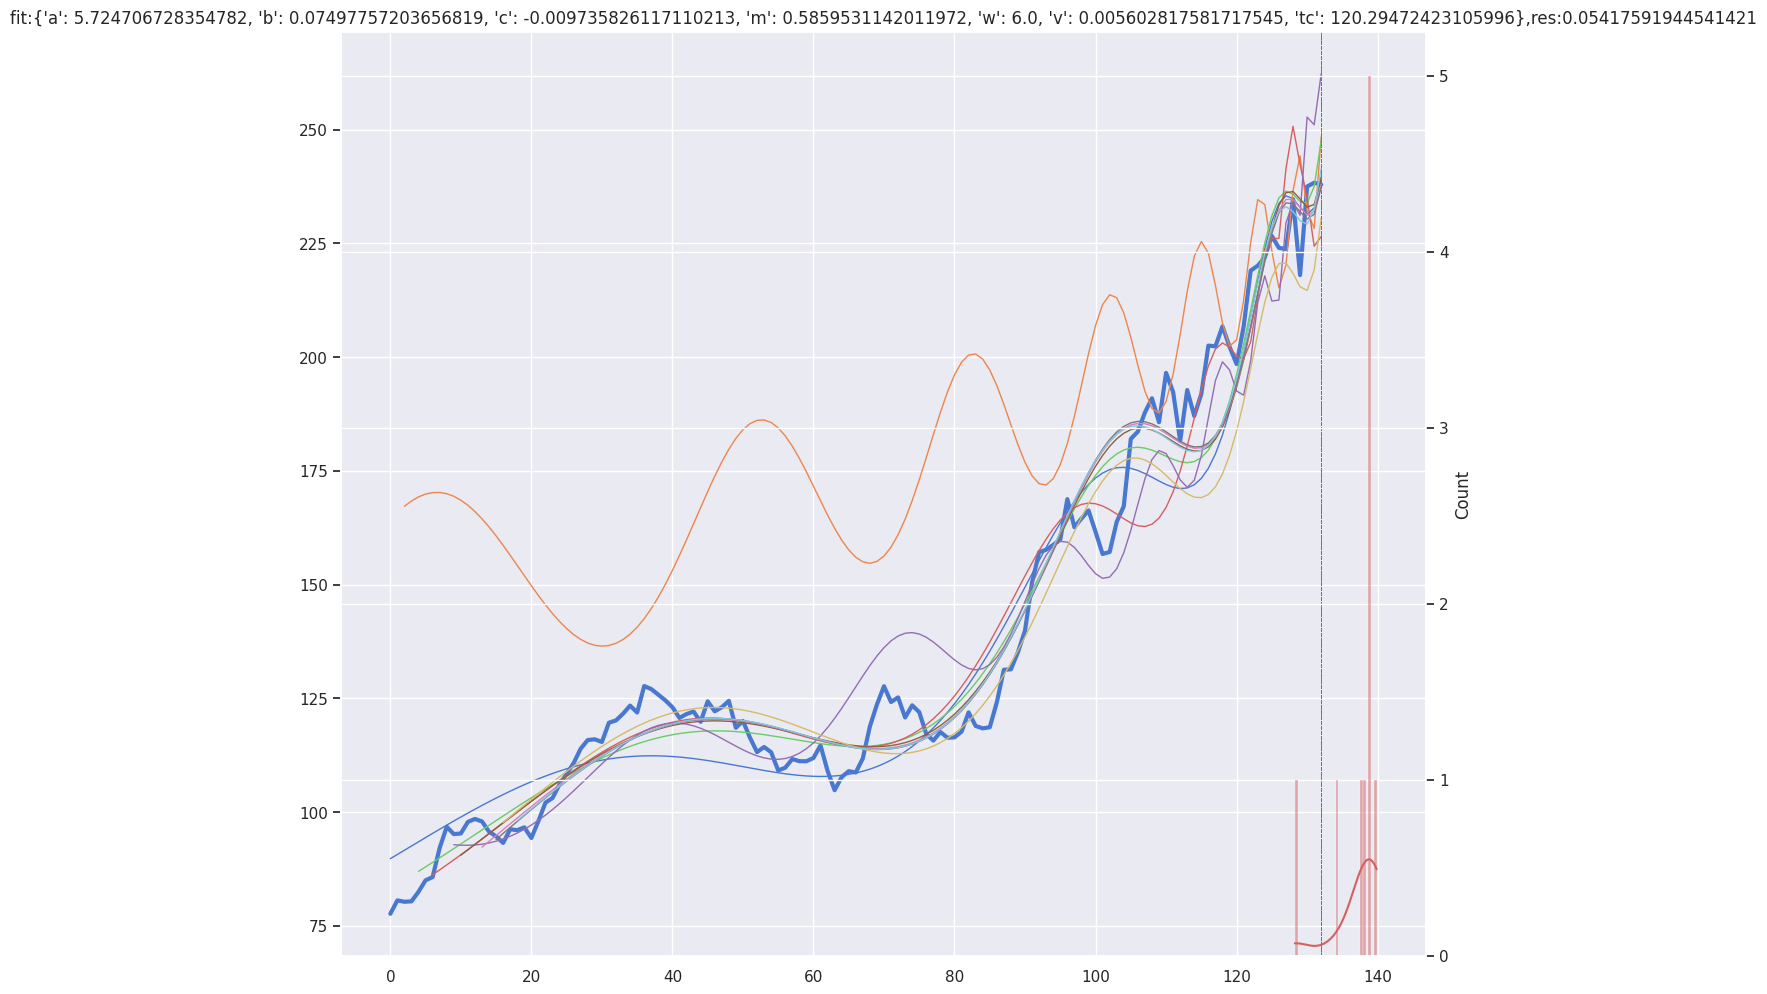

In [20]:
class Fit():

    def __init__(self):

        self.a=0
        self.b=0
        self.c=0
        self.tc=0
        self.m=0
        self.w=0
        self.v=0
        self.lppl_param_obj=self.lppl_init_params()
        self.lppl_real_signal=[]
        self.time=[]
        self.lppl_fit_residual=np.nan
        self.lppl_fitted_params={}

    def _set_signal(self,signal):
        self.lppl_real_signal=signal

    def lppl_func(self,param_dict):

        self.a, self.b, self.c, self.tc, self.m, self.w, self.v = param_dict['a'], param_dict['b'], param_dict['c'],param_dict['tc'],param_dict['m'], param_dict['w'], param_dict['v']
        t=self.time
        y= self.a - self.b*abs(self.tc-t)**self.m + (self.c*abs(self.tc-t)**self.m)*np.cos(self.w*np.log(abs(self.tc-t))-self.v) + (self.v*abs(self.tc-t)**self.m)*np.sin(self.w*np.log(abs(self.tc-t)))
        y[np.isnan(y)] = 0
        self.lppl_synth_signal=y
        return self.lppl_synth_signal

    def lppl_init_params(self):

        A=np.max(signal)*0.95
        AA=(np.max(signal)*1.1)
        T=(signal.count()*0.9)
        TT=(signal.count()*1.2)

        p = lmfit.Parameters()
        p.add('a', value=random.uniform(A,AA), min=A, max=AA)
        p.add('b',value=random.uniform(-1,1) ,min=-1, max=1)
        p.add('c',value=random.uniform(-1,1), min=-1, max=1)
        p.add('tc', value=random.uniform(T,TT), min=T, max=TT)
        p.add('m', value=random.uniform(0.1,0.9), min=0.1, max=0.9)
        p.add('w', value=random.uniform(6,16), min=6, max=16)
        p.add('v', value=random.uniform(-10,10), min=-10, max=10)
        self.lppl_param_obj=p
        return self.lppl_param_obj

    def lppl_fit(self):

        self.time=np.arange(len(self.lppl_real_signal))
        res_in=self.lppl_param_obj

        def lppl_residual(res_in):
            v = res_in.valuesdict()
            return (abs(self.lppl_func(v)-self.lppl_real_signal))

        mi = lmfit.minimize(lppl_residual,
                            self.lppl_param_obj,
                            method='differential_evolution',
                            nan_policy='omit')
        self.lppl_fit_residual=np.sqrt( np.mean(lppl_residual(mi.params)**2))
        self.lppl_fitted_params={'a':mi.params.valuesdict()['a'],
                                 'b':mi.params.valuesdict()['b'],
                                 'c':mi.params.valuesdict()['c'],
                                 'm':mi.params.valuesdict()['m'],
                                 'w': mi.params.valuesdict()['w'],
                                 'v':mi.params.valuesdict()['v'],
                                 'tc':mi.params.valuesdict()['tc']}
        return self.lppl_fit_residual, self.lppl_fitted_params

    def lppl_plot(self,ax):

        fitted_params=self.lppl_fitted_params
        self.lppl_synth_signal=self.lppl_func(fitted_params)
        TTT=len(np.arange(len(signal.values)))
#         plt.figure(figsize=(12,10))
#         plt.plot(self.time, np.exp(self.lppl_real_signal) , 'b', label='Stock',lw=1.5)
        ax.plot(np.arange(TTT-len(self.lppl_synth_signal),TTT), np.exp(self.lppl_synth_signal) ,lw=1)
        ax.set_title('fit:{},res:{}'.format(( self.lppl_fitted_params), ( self.lppl_fit_residual)))
#         ax.legend(loc=0)
        return ax

distTc=[]
distRes=[]
f, (ax1) = plt.subplots(1, 1,figsize=(14,12))
if __name__=='__main__':
    f = Fit()
    W=0.02
    ####################### max min different mode for different type
    part_range=[signal.values[j*int((W)*len(signal.values)):(j+1)*int((W)*len(signal.values))] for j in range(0,10)]
    minId = [np.argmin(part_range[i]) + i * int(W * len(signal.values)) for i in range(10)]#minId1直接按天排列进行lppl运算，没有切开选最低点。
    minId1=np.arange(80)
#    print(minId)
#    plt.figure(figsize=(14,12))
    ax1.plot(np.arange(len(signal.values)), np.exp(signal.values) , 'b', label='Stock',lw=3)

    for i in range(10):

        print(i)
        signalTemp=signal[minId[i]:]
        f._set_signal(signalTemp)
        lppl_fit_residual, lppl_fitted_params=f.lppl_fit()
        ax1=f.lppl_plot(ax1)
        distTc.append(minId[i]+lppl_fitted_params['tc'])
        distRes.append(lppl_fit_residual)
        plt.axvline(signal.count()-1,color='b', ls='--', lw=0.7)
    ax2=ax1.twinx()
    sns.histplot(distTc, bins=30, color="r", kde=True, ax=ax2)

    plt.show()



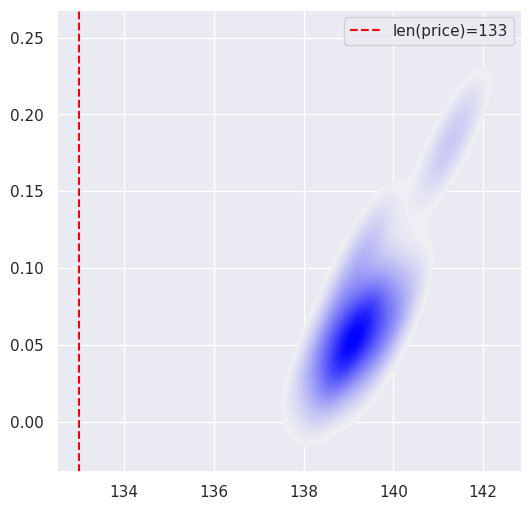

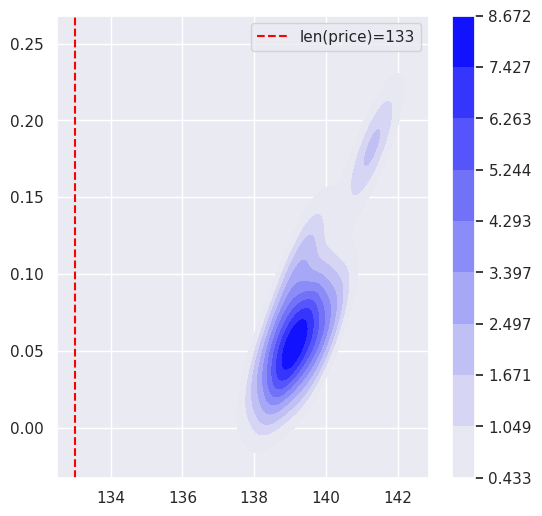

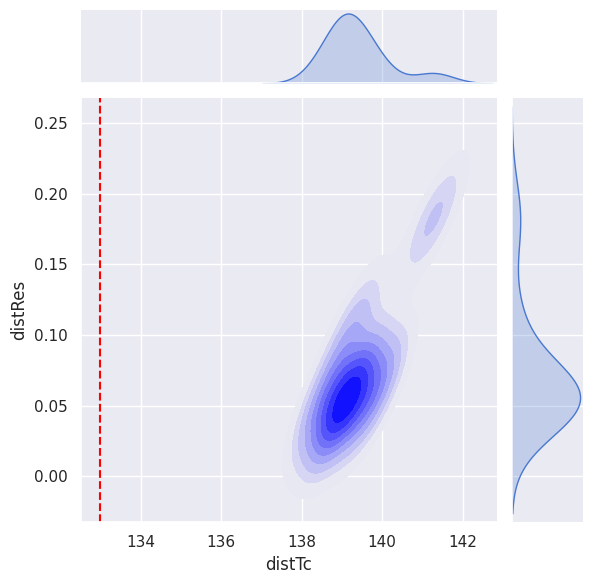

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 假设已经有 distTc, distRes, price
df = pd.DataFrame({'distTc': distTc, 'distRes': distRes})

# 计算 price 的长度
n_obs = len(signal)

# 1. KDE 密度图（带色彩映射）
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.light_palette("blue", as_cmap=True)
sns.kdeplot(x=distTc, y=distRes, cmap=cmap, fill=True, ax=ax, levels=60)

# 在图上画竖线
ax.axvline(n_obs, color="red", linestyle="--", linewidth=1.5, label=f"len(price)={n_obs}")
ax.legend()

# 2. 二维 KDE 直方图（带颜色条）
f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(x=distTc, y=distRes, fill=True, cbar=True, cmap=cmap, ax=ax)
ax.axvline(n_obs, color="red", linestyle="--", linewidth=1.5, label=f"len(price)={n_obs}")
ax.legend()

# 3. KDE 联合分布图
g = sns.jointplot(data=df, x="distTc", y="distRes", kind="kde", fill=True, cmap=cmap)
g.ax_joint.axvline(n_obs, color="red", linestyle="--", linewidth=1.5)

plt.show()


In [21]:
class Fit():

    def __init__(self):

        self.a=0
        self.b=0
        self.c=0
        self.tc=0
        self.m=0
        self.dt=0
        self.w=0
        self.dw=0
        self.v=0
        self.lppl_param_obj=self.lppl_init_params()
        self.lppl_real_signal=[]
        self.time=[]
        self.lppl_fit_residual=np.nan
        self.lppl_fitted_params={}

    def _set_signal(self,signal):
        self.lppl_real_signal=signal

    def lppl_func(self,param_dict):

        self.a, self.b, self.c, self.tc, self.m, self.dt, self.w, self.dw ,self.v = param_dict['a'], param_dict['b'], param_dict['c'],param_dict['tc'],param_dict['m'],param_dict['dt'], param_dict['w'],param_dict['dw'], param_dict['v']
        t=self.time
        y= self.a + (self.b*abs(self.tc-t)**self.m + self.c*abs(self.tc-t)**self.m*np.cos(self.w*np.log(abs(self.tc-t))+self.dw/(2*self.m)*np.log(1+(abs(self.tc-t)/self.dt)**(2*self.m))+self.v))/(1+(abs(self.tc-t)/self.dt)**(2*self.m))**0.5
        self.lppl_synth_signal=y
        return self.lppl_synth_signal

    def lppl_init_params(self):

        A=np.max(signal)*0.9
        AA=(np.max(signal)*1.05)
        T=(signal.count()*0.9)
        TT=(signal.count()*1.2)

        p = lmfit.Parameters()
        p.add('a', value=random.uniform(A,AA), min=A, max=AA)
        p.add('b',value=random.uniform(-1,1) ,min=-1, max=1)
        p.add('c',value=random.uniform(-1,1), min=-1, max=1)
        p.add('tc', value=random.uniform(T,TT), min=T, max=TT)
        p.add('m', value=random.uniform(0.1,0.9), min=0.1, max=0.9)
        p.add('dt', value=random.uniform(0,20*252), min=0, max=20*252)
        p.add('w', value=random.uniform(8,16), min=8, max=16)
        p.add('dw', value=random.uniform(0,50) , min=0, max=50)
        p.add('v', value=random.uniform(-10,10), min=-10, max=10)
        self.lppl_param_obj=p
        return self.lppl_param_obj

    def lppl_fit(self):

        self.time=np.arange(len(self.lppl_real_signal))
        res_in=self.lppl_param_obj

        def lppl_residual(res_in):
            v = res_in.valuesdict()
            return (abs(self.lppl_func(v)-self.lppl_real_signal))

        mi = lmfit.minimize(lppl_residual,
                            self.lppl_param_obj,
                            method='dual_annealing',
                            nan_policy='omit')
        self.lppl_fit_residual=np.sqrt( np.mean(lppl_residual(mi.params)**2))
        self.lppl_fitted_params={'a':mi.params.valuesdict()['a'],
                                 'b':mi.params.valuesdict()['b'],
                                 'c':mi.params.valuesdict()['c'],
                                 'm':mi.params.valuesdict()['m'],
                                 'dt':mi.params.valuesdict()['dt'],
                                 'w': mi.params.valuesdict()['w'],
                                 'dw':mi.params.valuesdict()['dw'],
                                 'v':mi.params.valuesdict()['v'],
                                 'tc':mi.params.valuesdict()['tc']}
        return self.lppl_fit_residual, self.lppl_fitted_params

    def lppl_plot(self,ax):

        fitted_params=self.lppl_fitted_params
        self.lppl_synth_signal=self.lppl_func(fitted_params)
        TTT=len(np.arange(len(signal.values)))
#         plt.figure(figsize=(12,10))
#         plt.plot(self.time, np.exp(self.lppl_real_signal) , 'b', label='Stock',lw=1.5)
        ax.plot(np.arange(TTT-len(self.lppl_synth_signal),TTT), np.exp(self.lppl_synth_signal) ,lw=1)
        ax.set_title('fit:{},res:{}'.format(( self.lppl_fitted_params), ( self.lppl_fit_residual)))
#         ax.legend(loc=0)
        return ax



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


/tmp/ipython-input-2014773082.py:27: RuntimeWarning: divide by zero encountered in divide
  y= self.a + (self.b*abs(self.tc-t)**self.m + self.c*abs(self.tc-t)**self.m*np.cos(self.w*np.log(abs(self.tc-t))+self.dw/(2*self.m)*np.log(1+(abs(self.tc-t)/self.dt)**(2*self.m))+self.v))/(1+(abs(self.tc-t)/self.dt)**(2*self.m))**0.5
/tmp/ipython-input-2014773082.py:27: RuntimeWarning: invalid value encountered in multiply
  y= self.a + (self.b*abs(self.tc-t)**self.m + self.c*abs(self.tc-t)**self.m*np.cos(self.w*np.log(abs(self.tc-t))+self.dw/(2*self.m)*np.log(1+(abs(self.tc-t)/self.dt)**(2*self.m))+self.v))/(1+(abs(self.tc-t)/self.dt)**(2*self.m))**0.5


ValueError: The user-provided objective function must return a scalar value.

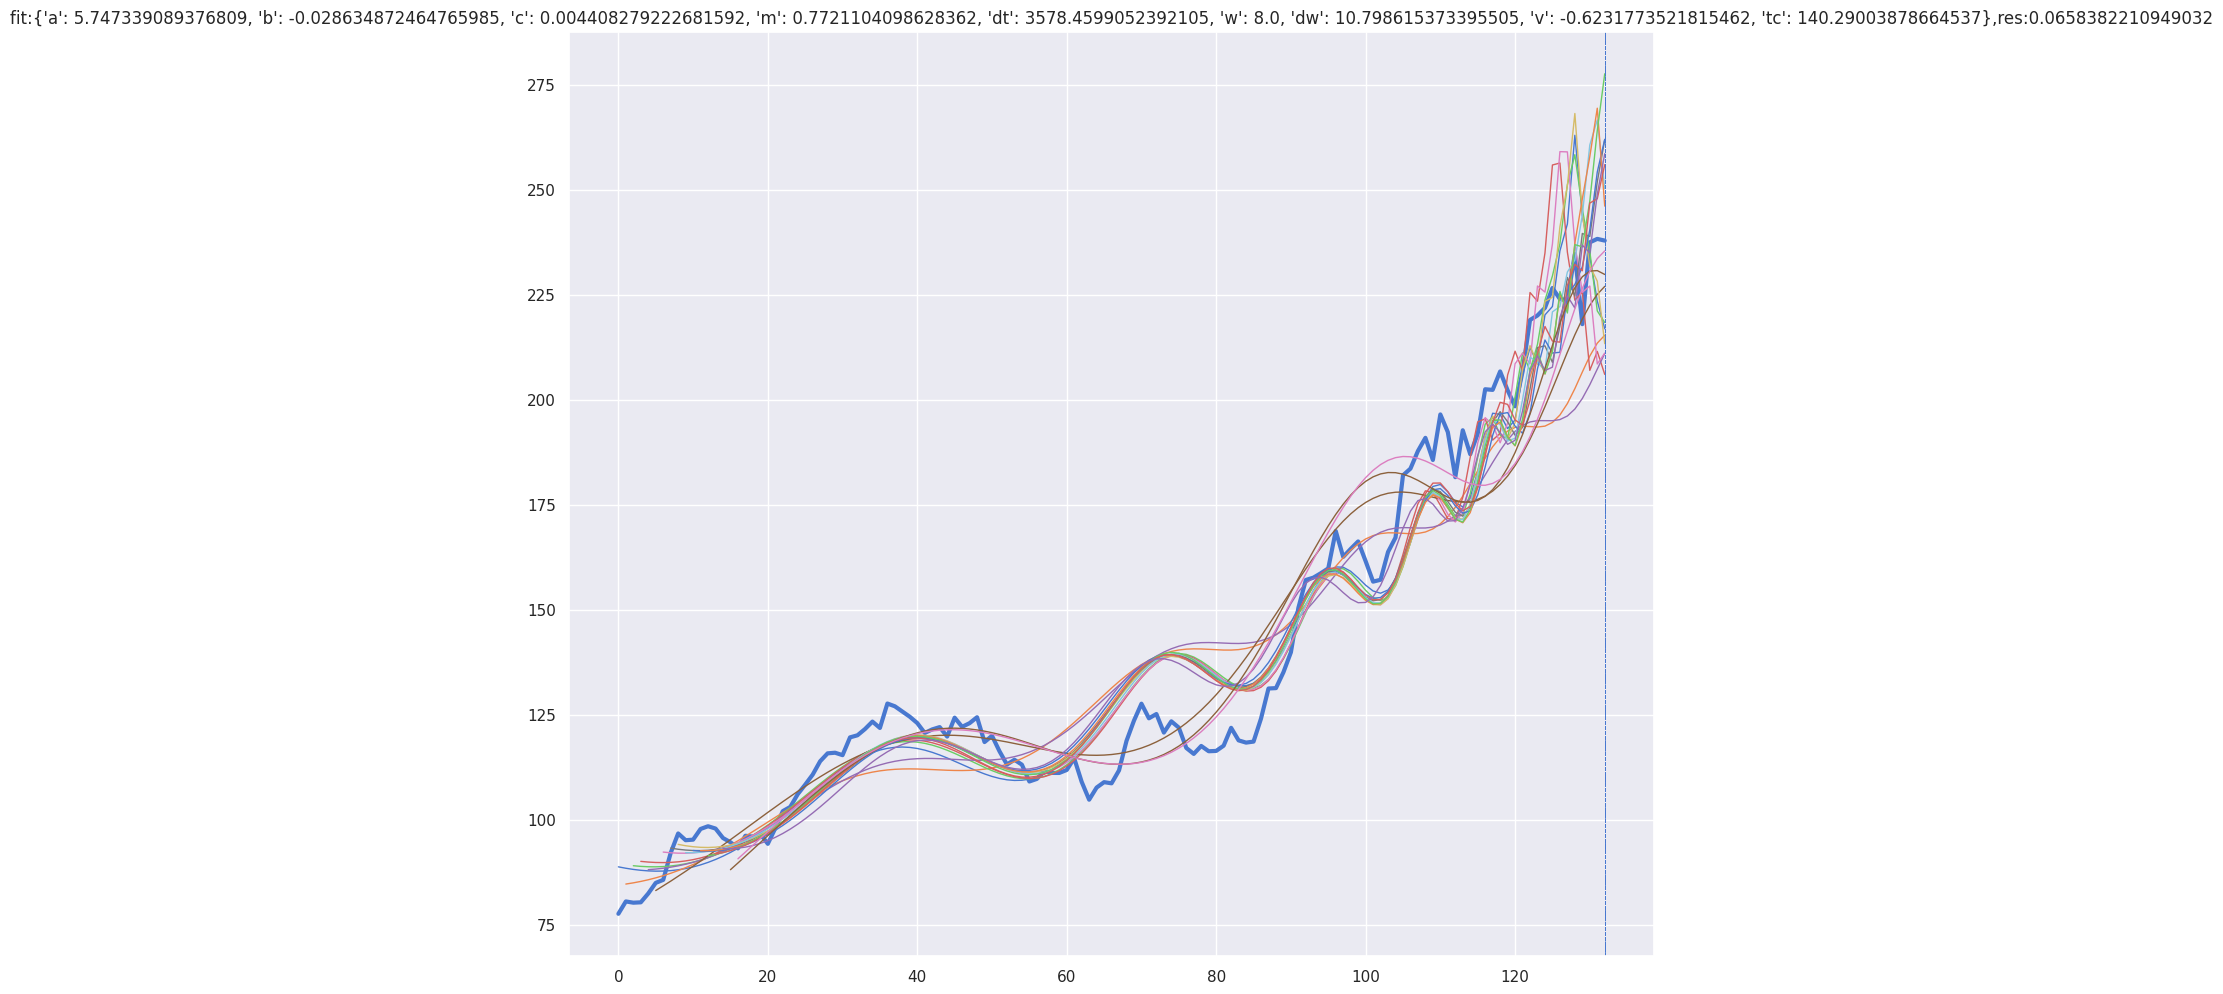

In [23]:
distTc=[]
distRes=[]
f, (ax1) = plt.subplots(1, 1,figsize=(14,12))
if __name__=='__main__':
    f = Fit()
    W=0.02
    ####################### max min different mode for different type
    #part_range=[signal.values[j*int((W)*len(signal.values)):(j+1)*int((W)*len(signal.values))] for j in range(0,10)]
    #minId=[np.where(signal.values==min(part_range[i]))[0][0] for i in range(9)] #!!! Change here for different bubble.
    minId1=np.arange(80)
#     print(minId)
#     plt.figure(figsize=(14,12))
    ax1.plot(np.arange(len(signal.values)), np.exp(signal.values) , 'b', label='Stock',lw=3)
    for i in range(20):
        print(i)
        signalTemp=signal[minId1[i]:]
        f._set_signal(signalTemp)
       # plt.figure(figsize=(12,10))
        lppl_fit_residual, lppl_fitted_params=f.lppl_fit()
        ax1=f.lppl_plot(ax1)
        distTc.append(minId1[i]+lppl_fitted_params['tc'])
        distRes.append(lppl_fit_residual)
        #plt.axvline(np.where(signal.values==min(part_range[i]))[0][0]+lppl_fitted_params['tc'],color='r', ls='--', lw=1.5)  # Change here for different bubble
        plt.axvline(signal.count()-1,color='b', ls='--', lw=0.7)
    ax2=ax1.twinx()
    #fig_ii=ax2.hist(distTc,bins=40,color='r',density=True)
    sns.histplot(distTc, bins=30, color="r", kde=True, ax=ax2)
    plt.show()

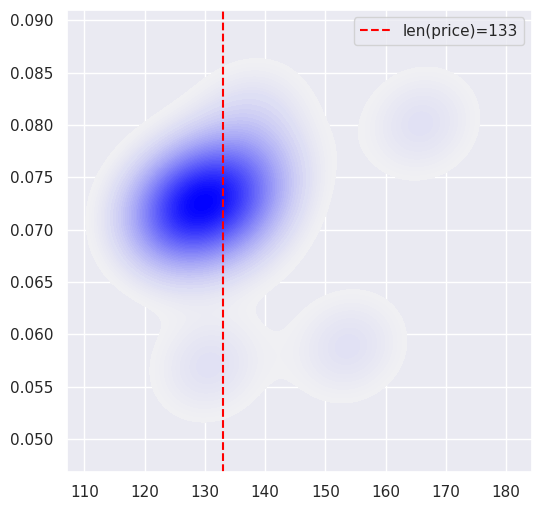

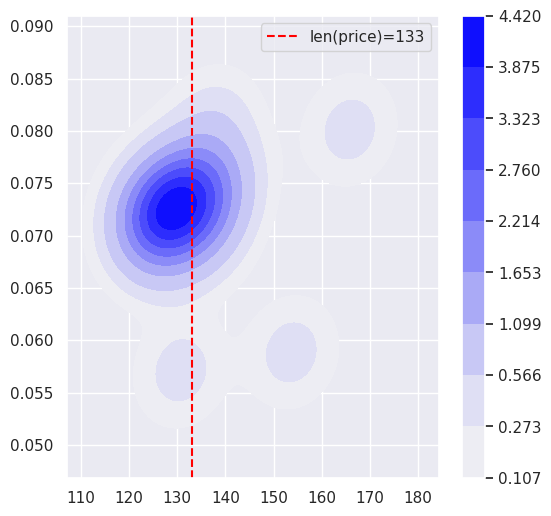

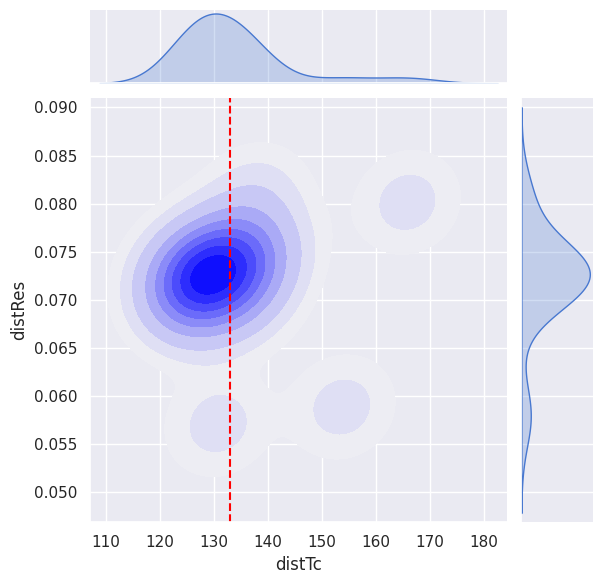

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 假设已经有 distTc, distRes, price
df = pd.DataFrame({'distTc': distTc, 'distRes': distRes})

# 计算 price 的长度
n_obs = len(signal)

# 1. KDE 密度图（带色彩映射）
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.light_palette("blue", as_cmap=True)
sns.kdeplot(x=distTc, y=distRes, cmap=cmap, fill=True, ax=ax, levels=60)

# 在图上画竖线
ax.axvline(n_obs, color="red", linestyle="--", linewidth=1.5, label=f"len(price)={n_obs}")
ax.legend()

# 2. 二维 KDE 直方图（带颜色条）
f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(x=distTc, y=distRes, fill=True, cbar=True, cmap=cmap, ax=ax)
ax.axvline(n_obs, color="red", linestyle="--", linewidth=1.5, label=f"len(price)={n_obs}")
ax.legend()

# 3. KDE 联合分布图
g = sns.jointplot(data=df, x="distTc", y="distRes", kind="kde", fill=True, cmap=cmap)
g.ax_joint.axvline(n_obs, color="red", linestyle="--", linewidth=1.5)

plt.show()
